# Evolutionary Algorithms for Combinatorial Multi-Knapsack
## EA Functions
### Imports and Config

In [25]:
import time, array, random, copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from deap import algorithms, base, benchmarks, tools, creator
import seaborn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### Instance Creation

In [35]:


def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst
def instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate):
    with open(file_name) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d


### Population Generation, Fitness, Mutation, and Xover

In [27]:
def eval_fitness(individual, instance):
    n_kp = instance.get("n_kp")
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*n_kp
    knapsacks_profit = [0]*n_kp
    
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] <= n_kp:
            knapsack = individual[i] - 1
            knapsacks_weight[knapsack] += weights[i]
            knapsacks_profit[knapsack] += profits[i]
            for j in range(len(individual)):
                if knapsack == individual[j] - 1:
                    knapsacks_profit[knapsack] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)

    for i in range(n_kp):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    f1 += n_kp * min(knapsacks_profit)
    return f1, f2

def uniform(low, m, n_kp):
    n = [0]*m
    for i in range(0,m):
        n[i] = random.randint(0,n_kp)
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x, n_kp):
    index = random.randrange(len(x))
    var = random.randint(0,n_kp)
    x[index] = var
    return x,


### Running EA

In [28]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

### Single Execution Script

In [33]:
def execute_EA(instance):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0))
    creator.create("Individual", list, typecode='i', 
                   fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    num_kp = instance.get("n_kp")
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
    NDIM = 2
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    #toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mate", favorite_child_xover)
    #toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
    toolbox.register("mutate", lambda x: mutation(x, num_kp),)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = instance.get("pop_size")
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    res,logbook = run_ea(toolbox)

    fronts = tools.emo.sortLogNondominated(res, len(res))
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    fig, ax = plt.subplots(1, figsize=(4,4))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                     x=df.columns[0], y=df.columns[1], 
                     color=plot_colors[i])
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');
    return res,logbook, fronts

### Multiple Instance Testing Function

In [ ]:
### TODO: Make this function

## Running and Testing
### Single Execution

gen	nevals	max    	avg    
0  	500   	36018.5	12819.8
1  	431   	36018.5	13779.1
2  	417   	36018.5	14431.4
3  	431   	37229  	14796.5
4  	423   	37229  	15160  
5  	436   	37229  	15504.6
6  	433   	37229  	15871.4
7  	416   	38111.4	16643.8
8  	412   	38111.4	16331.4
9  	431   	39339.4	16502  
10 	423   	39339.4	16144.2
11 	429   	40071.8	16166  
12 	426   	40071.8	16583.2
13 	437   	40888.2	17314.6
14 	426   	40888.2	16952.9
15 	431   	40888.2	17162.3
16 	432   	40888.2	17121.2
17 	423   	41554.3	16486.6
18 	437   	42529.1	17601.8
19 	425   	42529.1	18124.7
20 	418   	43495.5	18153.5
21 	421   	43495.5	17725.4
22 	430   	43495.5	16886.8
23 	420   	43495.5	17836.5
24 	414   	43495.5	18353.2
25 	424   	43561  	18366.1
26 	433   	43899.5	18355.5
27 	440   	44172.4	18543.1
28 	435   	44172.4	18001.4
29 	428   	44172.4	18083.2
30 	436   	45984.2	17680.6
31 	416   	45984.2	17528.7
32 	418   	45984.2	18324.9
33 	415   	46044.3	17953.4
34 	420   	46044.3	19125.3
35 	418   	46242.5	17825  
3

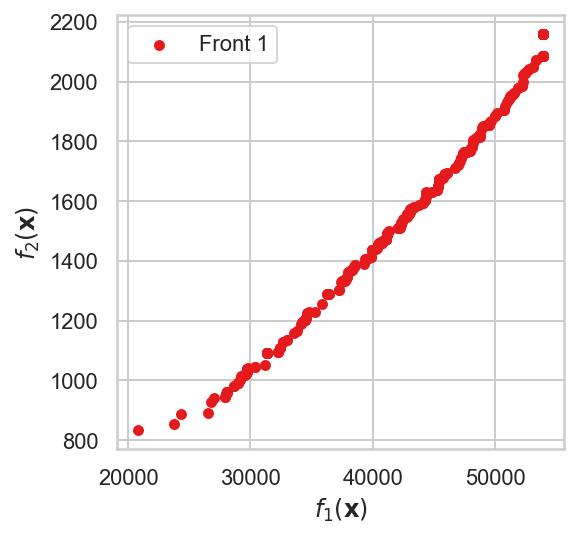

In [36]:
#file_name, m, pop_size, num_gen, mut_rate, xover_rate
instance = instance_create('jeu_100_25_1.txt', 3, 500, 200, .05, .8)
%time res, logbook, fronts = execute_EA(instance)

### Generating Instances

In [31]:
### TODO: create function to generate all the instances we need for testing


117
